1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


<ipython-input-32-cb56d180627a>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label=class_names[int(test_labels[i].numpy())]


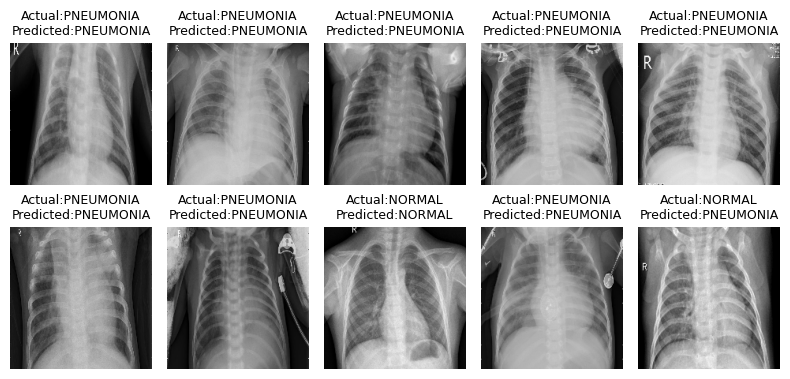

In [32]:
## PROJECT: PNEUMONIA DETECTION FROM CHEST X-RAY
# created by Bareera Mushthak

# to upload and Unzip Dataset
from google.colab import files
uploaded = files.upload()
# To use kaggle inside colab
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# To download Dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

import zipfile
zip_ref=zipfile.ZipFile('chest-xray-pneumonia.zip','r') # To open the zip file
zip_ref.extractall('/content/chest_xray') # To extract all the contents to a folder
zip_ref.close() # To close the zipfile

# Import necessary Library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory

#LOAD DATASET
train_dataset= image_dataset_from_directory('/content/chest_xray/chest_xray/train',
                                      labels='inferred',
                                      label_mode='binary',
                                      image_size=(180,180),
                                      batch_size=32,
                                      shuffle='True'
                                      )
#Load the validation dataset
val_dataset= image_dataset_from_directory('/content/chest_xray/chest_xray/val',
                                      labels='inferred',
                                      label_mode='binary',
                                      image_size=(180,180),
                                      batch_size=32,
                                      shuffle='True'
                                      )
# Load the test dataset
test_dataset= image_dataset_from_directory('/content/chest_xray/chest_xray/test',
                                      labels='inferred',
                                      label_mode='binary',
                                      image_size=(180,180),
                                      batch_size=32,
                                      shuffle='False'
                                      )

class_names=train_dataset.class_names
#Data Normalization
normalization_layer=tf.keras.layers.Rescaling(1./255) #Define a normalization layer
# Apply normalization to datasets
train_dataset=train_dataset.map(lambda x,y: (normalization_layer(x),y))
val_dataset=val_dataset.map(lambda x,y: (normalization_layer(x),y))
test_dataset=test_dataset.map(lambda x,y: (normalization_layer(x),y))
#To display sample images from train set
import matplotlib.pyplot as plt
#class_names=train_dataset.class_names #to automatically asign based on folders
plt.figure(figsize=(8,4))
for images,labels in train_dataset.take(1):
  for i in range(10):
    ax=plt.subplot(2,5,i+1)
    plt.imshow(images[i].numpy())
    #label_text='Pneumonia' if labels[i].numpy() == 1 else 'Healthy'
    label_text=class_names[int(labels[i].numpy())]
    plt.title(label_text)
    plt.axis("off")
plt.tight_layout()
plt.show()


# CNN Model building

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

model = Sequential([
                    Input(shape=(180,180,3)),
                    Conv2D(32,(3,3),activation='relu'),
                    MaxPooling2D(pool_size=[2,2]),
                    Flatten(),
                    Dense(128,activation='relu'), # fully connected layer with 128 neurons connects every neuron to the flattened vector
                    Dropout(0.5),   # To disable 50% of neurons to prevent the model from overfitting
                    Dense(1,activation='sigmoid') # Only 1 neuron for binary classification
                                                  # Sigmoid squashes the output to a range between 0 and 1
                    ])

# Model Compilation and Training
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history= model.fit(train_dataset,epochs=10,validation_data=val_dataset)

# Evaluation and Confusion mATRIX
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true= []
y_pred= []

for images, labels in test_dataset:
    predictions=model.predict(images)
    predictions=(predictions>0.5).astype(int)
    y_pred.extend(predictions.flatten())
    y_true.extend(labels.numpy())

#y_pred=(model.predict(ds_test.batch(32))>0.5).astype("int32")  # To predict labels
#y_true=np.concatenate([y for x,y in ds_test],axis=0)
y_true=np.array(y_true)
y_pred=np.array(y_pred)
# To plot confusion matrix
cm = confusion_matrix(y_true,y_pred) # to create confusion matrix

plt.figure(figsize=(5,5))  # To plot confusion matrix
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#To show predictions on test images
for test_images,test_labels in test_dataset.take(1):
  predictions=model.predict(test_images)
  predictions=(predictions>0.5).astype(int)
  plt.figure(figsize=(8,4))
  for i in range(10):
    ax=plt.subplot(2,5,i+1)
    plt.imshow(test_images[i].numpy())
    #label_text='Pneumonia' if labels[i].numpy() == 1 else 'Healthy'
    true_label=class_names[int(test_labels[i].numpy())]
    predicted_label=class_names[int(predictions[i][0])]
    plt.title(f"Actual:{true_label}\nPredicted:{predicted_label}",fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()